Below, we will be importing the appropriate datasets (Cardiff.npy, Aberporth.npy, Valley.npy). We will also be importing some of our dependencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

valley = np.load("valley.npy")
cardiff = np.load("cardiff.npy")
aberporth = np.load("aberporth.npy")

dset_name = 'Cardiff'
dset = cardiff

print(dset)



[[1977.     9.    18.3    8.1    0.    48.6]
 [1977.    10.    15.4    9.     0.    76. ]
 [1977.    11.    10.3    4.7    4.   147.9]
 ...
 [2023.    10.    17.4    9.6    0.   178.4]
 [2023.    11.    12.2    5.1    4.   202. ]
 [2023.    12.    10.9    5.7    4.   158.8]]


Next, we will be extracting out the 6 columns from each dataset (Year, Month, Minimum Temperature, Maximum Temperature, # Frost Days (below 0 degrees celcius), Monthly Rainfall (mm)). 

Further, we will be using a naive decomposition method (Classical Seasonal Decomposition) - a type of time series analysis useful before selecting appropriate models. We can define this formally in future if necessary. We will then be plotting the results.

Finally, it may be nice to implement Exponential Smoothing as a pre-processing step before analysis, to reduce short-term noise.



            rainfall  max_temp  min_temp  frost_days  month
1977-09-01      48.6      18.3       8.1         0.0      9
1977-10-01      76.0      15.4       9.0         0.0     10
1977-11-01     147.9      10.3       4.7         4.0     11
1977-12-01      88.0       9.6       4.6         2.0     12
1978-01-01     134.1       7.5       2.0         6.0      1
...              ...       ...       ...         ...    ...
2023-08-01      94.2      21.4      12.8         0.0      8
2023-09-01     107.0      22.0      13.1         0.0      9
2023-10-01     178.4      17.4       9.6         0.0     10
2023-11-01     202.0      12.2       5.1         4.0     11
2023-12-01     158.8      10.9       5.7         4.0     12

[556 rows x 5 columns]


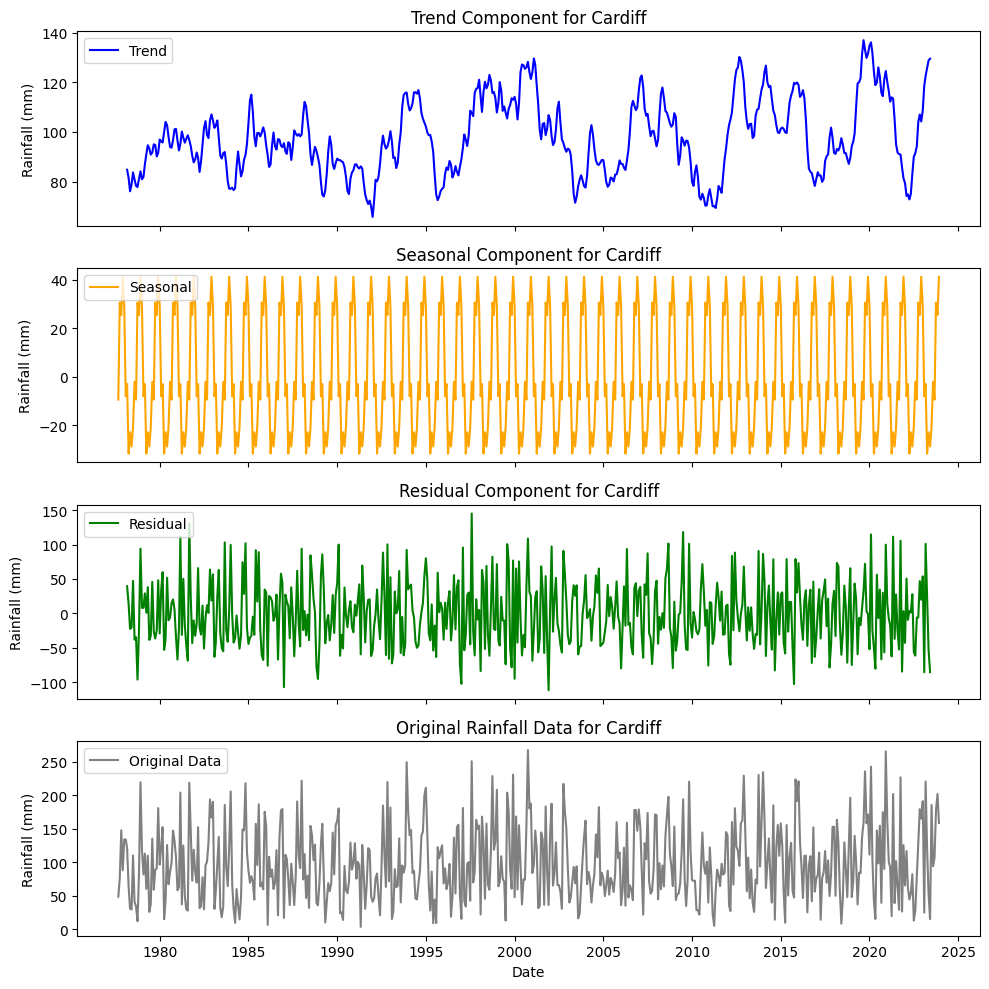

In [2]:
# Modify as a function handling all three datasets. Currently testing with Cardiff.
years = dset[:, 0]
months = dset[:, 1]
min_temps = dset[:, 3]
max_temps = dset[:, 2]
frost_days = dset[:, 4]
monthly_rainfalls = dset[:, 5]

dates = pd.to_datetime({'year': years, 'month': months, 'day': 1})
df = pd.DataFrame({'date': dates, 'rainfall': monthly_rainfalls, 'max_temp': max_temps, 'min_temp': min_temps,
                   'frost_days': frost_days})


df.set_index('date', inplace=True)
df = df.sort_index()
df = df.asfreq("MS")


# Modelling assumption; Level + Trend + Seasonality + Noise (additive).
# Effective for linear trends and linear seasonality (easy to see via plots).
# I.e. linear seasonality has same frequency and amplitude over time. Linear trend is a straight line.
# Multiplicative models can effectively represent non-linear time series.

# Automatic decomposition. This is the naive (classical) method.
# Decomposes into trend, seasonal and residual components.
# Must use a specific column (rainfall), which is a Pandas Series.

df = df.dropna()
new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
# Now reassign the new index to df (ensuring no length mismatch)
df.index = new_index[:len(df)]  # Slice to ensure the lengths match

df['month'] = df.index.month

print(df)
result = seasonal_decompose(df['rainfall'], model='additive')

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10), sharex=True)

 # Trend
axes[0].plot(result.trend, label='Trend', color='blue')
axes[0].set_title(f'Trend Component for {dset_name}')
axes[0].set_ylabel('Rainfall (mm)')
axes[0].legend(loc='upper left')

# Seasonal
axes[1].plot(result.seasonal, label='Seasonal', color='orange')
axes[1].set_title(f'Seasonal Component for {dset_name}')
axes[1].set_ylabel('Rainfall (mm)')
axes[1].legend(loc='upper left')


# Residual
axes[2].plot(result.resid, label='Residual', color='green')
axes[2].set_title(f'Residual Component for {dset_name}')
axes[2].set_ylabel('Rainfall (mm)')
axes[2].legend(loc='upper left')

# Original data
axes[3].plot(df['rainfall'], label='Original Data', color='gray')
axes[3].set_title(f'Original Rainfall Data for {dset_name}')
axes[3].set_ylabel('Rainfall (mm)')
axes[3].legend(loc='upper left')
    
# Common X-axis labels[dset]
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Below should be left for plots with labelled axes and such.
# This may be inherent in the DataFrame information.

For Cardiff data, this demonstrates that monthly rainfall (our target variable) has the following characteristics:

1. No specific linear trend.
2. Strong seasonality component (need to specify plots for which months).
3. Residuals are fairly randomly distributed, no particular issues with sensor readings (so far).

Now we will produce some more time series analysis, specifically, looking at autocorrelation and partial autocorrelation (ACF & PACF).

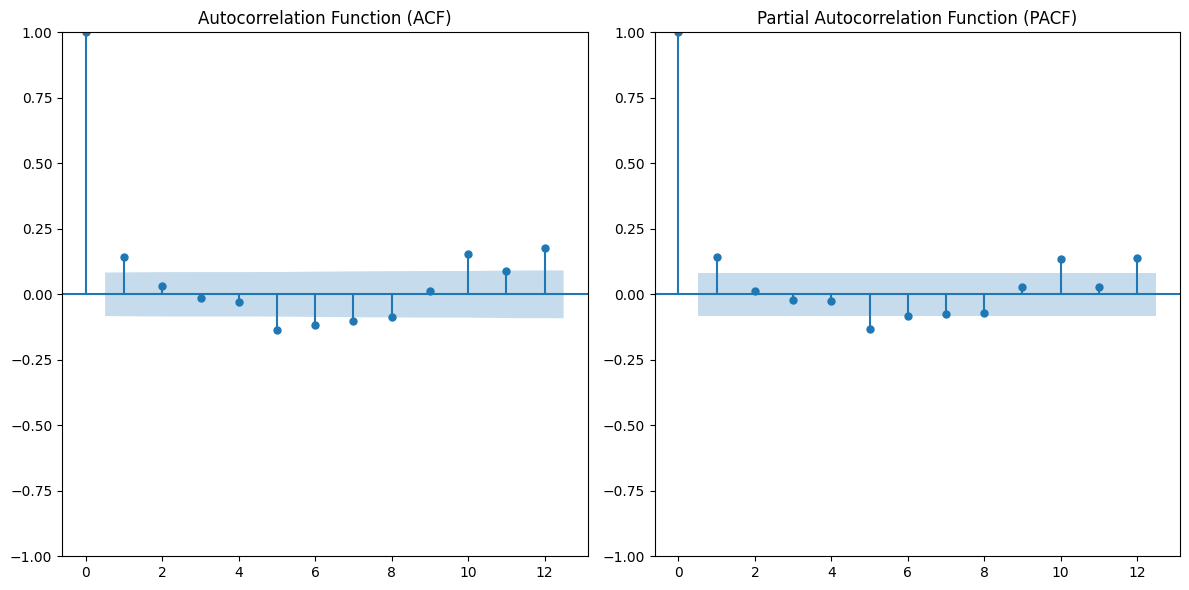

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df['rainfall'], ax=plt.gca(), lags=12)
plt.title('Autocorrelation Function (ACF)')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(df['rainfall'], ax=plt.gca(), lags=12)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


These seem to present a cyclical autocorrelation, which reaffirms the strong seasonality trend from our previous decomposition.


Below, we could test for stationarity (Dickey-Fuller test), which is also provided by statsmodels. Also known as weak stationarity, it refers to three properties (two of which we have demonstrated do not hold for our dataset):

1. Constant mean over time.
2. Constant variance over time.
3. Autocovariance depends only on distance (lag) and not on time.

We have demonstrated non-constant variance through seasonality and also autocovariance with some time dependence as per above, also related to seasonality.

Now I will move onto model selection. Some considerations:

1. Preference for multi-step models, i.e. more complex models considering long-term trends. 
2. Multivariate problem, specifically, future monthly rainfall as a result of monthly max/min temperatures and historical rainfall.
3. Non-stationarity, some classical models require stationary data, such as VARMA and VAR, multivariate extensions of the traditional ARMA and AR.

Our first model will be VARMAX, however, in order to satisfy stationarity, we need to include differencing in the pre-processing step (in particular seasonal differencing). It may also be useful to plot a multiplicative model (separately) to see if there are any non-linear trends.

Our second model will be XGBoost, will need to convert the series problem into a supervised problem for viability, however.

Our third model will be LSTM. This will hopefully be the most accurate model, as similarly to VAR it actually captures temporal dynamics. Differencing, however, is not required. Although, may be useful to stabilise predictions.

For model evaluation, we can use the MAE, MASE, MAPE & RMSE metrics on a final validation set. Also we will include plots for feature importance (not sure if importance weighting will be required) in results.


Now, we will begin by implementing the VARMAX model. This includes seasonal differencing as a pre-processing step. (As for all models), we will finalise by testing with time series cross-validation (scikit-learn has an implementation of this for Pandas Series).
 

In [16]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

# Selecting appropriate columns.
df_new = df[['rainfall', 'max_temp', 'min_temp']]

# Augmented Dickey-Fuller to test for stationarity.
for column in df_new.columns:
    result = adfuller(df_new[column])
    print('ADF statistic:', result[0])
    print('p-value:', result[1])

# Seasonal differencing.
df_diff = df_new - df_new.shift(12)
df_diff = df_diff.dropna()

# Time series split.
tscv = TimeSeriesSplit(n_splits=2)

# Define ranges for p and q
p_range = range(1, 3)  # Adjust as needed, e.g., 0 to 2
q_range = range(1, 3)

results = []

# Time series cross-validation with iterative tuning
for p in p_range:
    for q in q_range:
        mae_res = []
        mse_res = []
        rmse_res = []

        # Time series cross-validation
        for train_index, test_index in tscv.split(df_diff):
            train_data = df_diff.iloc[train_index]
            test_data = df_diff.iloc[test_index]
        

            # Fit the VARMAX model with current p and q
            try:
                model = VARMAX(train_data, order=(p, q))
                results_fit = model.fit(maxiter=1000, disp=False)

                # Forecast the same number of steps as the size of the test set
                forecast = results_fit.forecast(steps=len(test_data))

                # Calculate evaluation metrics
                mae = np.mean(np.abs(test_data['rainfall'].values - forecast['rainfall'].values))
                mse = np.mean((test_data['rainfall'].values - forecast['rainfall'].values) ** 2)
                rmse = np.sqrt(mse)

                # Append metrics to lists
                mae_res.append(mae)
                mse_res.append(mse)
                rmse_res.append(rmse)

            except Exception as e:
                print(f"Model fitting failed for order ({p}, {q}): {e}")

        # Store AIC and BIC results along with order
        results.append({
            'order': (p, q),
            'AIC': results_fit.aic,
            'BIC': results_fit.bic,
            'MAE': np.mean(mae_res),
            'RMSE': np.mean(rmse_res)
        })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Find optimal orders based on AIC and BIC
optimal_aic = results_df.loc[results_df['AIC'].idxmin()]
optimal_bic = results_df.loc[results_df['BIC'].idxmin()]

print("Optimal order based on AIC:", optimal_aic['order'], "with AIC:", optimal_aic['AIC'])
print("Optimal order based on BIC:", optimal_bic['order'], "with BIC:", optimal_bic['BIC'])





ADF statistic: -4.693960233704873
p-value: 8.63789492282613e-05
ADF statistic: -4.044914975510987
p-value: 0.0011927491961655674
ADF statistic: -4.701881910050274
p-value: 8.347042616593876e-05


/home/thomast/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
/home/thomast/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/thomast/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
/home/thomast/.local/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
/home/thomast/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/thomast/.local/lib/

Optimal order based on AIC: (1, 1) with AIC: 6823.500506623066
Optimal order based on BIC: (1, 1) with BIC: 6928.649383148217


Now we will implement the XGBoost model.

MAE: 42.92938495096953
MSE: 3260.02745957336
RMSE: 57.09665016069997
MAE: 43.39784507129503
MSE: 3044.4693192506297
RMSE: 55.176709934995486


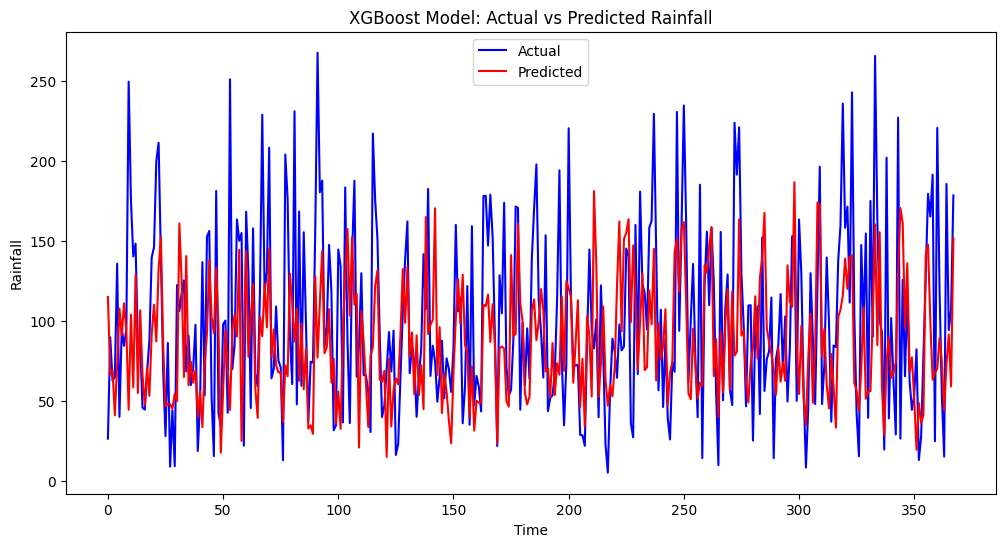

<Figure size 1000x600 with 0 Axes>

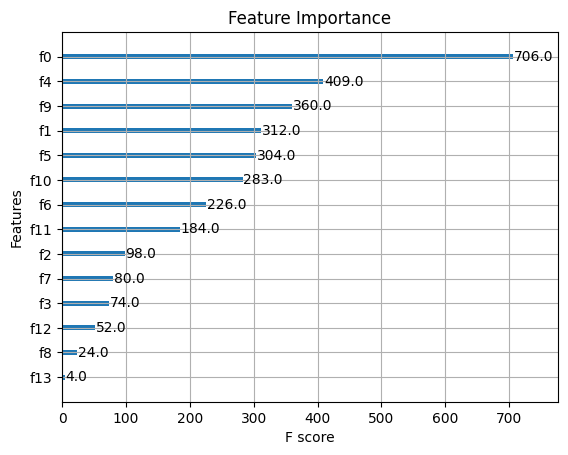

/home/thomast/.local/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
/home/thomast/.local/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfo

In [7]:
from xgboost import XGBRegressor, plot_tree, plot_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# Sliding window functionality.
def series_to_supervised(df, n_in=2, n_out=1, dropnan=True):
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

    for i in range(0, n_out):
        cols.append(df.shift(-i))

    agg = pd.concat(cols, axis=1)
    
    if dropnan:
        agg.dropna(inplace=True)

    return agg.values

# Initialize the model
model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Prepare dataset
dset = series_to_supervised(df)

# Separate features and target (index 0 is rainfall).
X = dset[:, 1:]
y = dset[:, 0]

# Simple approach - TimeSeriesSplit. Can also use walk-forward validation.
tscv = TimeSeriesSplit(n_splits=2)

# Store predictions for plotting
all_predictions = []
all_actual = []

for train_index, test_index in tscv.split(X):
    # Use splits
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Store predictions and actual values
    all_predictions.extend(y_pred)
    all_actual.extend(y_test)

    # Evaluate model performance
    mae = np.mean(np.abs(y_test - y_pred))  # MAE
    mse = np.mean((y_test - y_pred) ** 2)   # MSE
    rmse = np.sqrt(mse)                     # RMSE
    
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(all_actual, label='Actual', color='blue')
plt.plot(all_predictions, label='Predicted', color='red')
plt.title('XGBoost Model: Actual vs Predicted Rainfall')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()


# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model)
plt.title("Feature Importance")
plt.show()

# Visualize a specific tree using dtreeviz
import dtreeviz

# Visualize a specific tree using dtreeviz
# Get the booster from the fitted model (use the last fitted model)
booster = model.get_booster()

# Specify the tree index you want to visualize (e.g., tree index 0)
tree_index = 0

# Prepare feature names (assuming you have feature names)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]

# Create the visualization for regression (no class names needed)
viz_model = dtreeviz.model(booster,
                      X_train,
                      y_train,
                      target_name="Rainfall",
                      feature_names=feature_names,
                      tree_index=tree_index)

# Display the visualization
v = viz_model.view()  # Render as SVG into internal object 
v.show()              # Pop up window (if supported by your environment)
v.save("/tmp/rainfall_tree.svg")  # Optionally save as SVG



Now we will implement the LSTM model.

/home/thomast/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/stepWARNING:tensorflow:5 out of the last 21 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0xfffea6e77f60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
MAE: 44.51963916723279
RMSE: 59.07781620808824
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE: 38.9326580821604
RMSE: 47.961394253878524
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE: 45.88830111959706
RMSE: 58

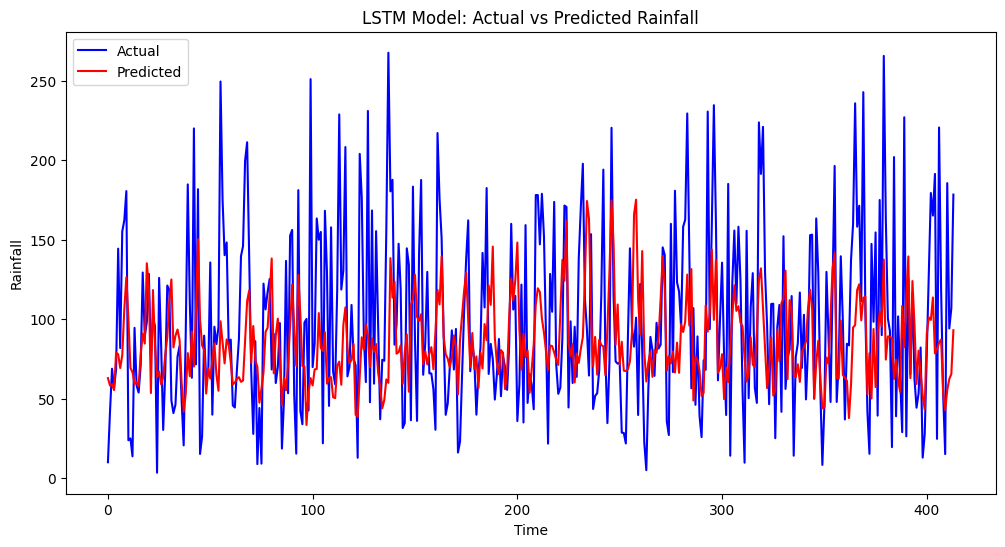

AttributeError: The layer sequential_10 has never been called and thus has no defined input.

In [22]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from keras import backend as K
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is already defined and preprocessed
dset = series_to_supervised(df)

# Separate features and target (index 0 is rainfall).
X = dset[:, 1:]
y = dset[:, 0]

tscv = TimeSeriesSplit(n_splits=3)

all_predictions = []
all_actual = []

# Defining the LSTM model (manually for now).
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(2, 1)))  # Correct input shape
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

sample = None

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # Apply Robust Scaling
    scaler_X = RobustScaler()
    X_train = scaler_X.fit_transform(X_train)  # Fit on training data
    X_test = scaler_X.transform(X_test)        # Transform test data

    scaler_y = RobustScaler()
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))  # Fit on training data
    y_test = scaler_y.transform(y_test.reshape(-1, 1))        # Transform test data

    # Reshape X for LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # (samples, timesteps, features)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    if not isinstance(sample, np.ndarray):
        sample = X_train

    # Fit the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform the predictions and y_test
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test = scaler_y.inverse_transform(y_test)

    # Store predictions and actual values
    all_predictions.extend(y_pred.flatten())
    all_actual.extend(y_test.flatten())

    # Error statistics
    mae = np.mean(np.abs(y_test - y_pred))  # MAE
    mse = np.mean((y_test - y_pred) ** 2)   # MSE
    rmse = np.sqrt(mse)                     # RMSE
    
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(all_actual, label='Actual', color='blue')
plt.plot(all_predictions, label='Predicted', color='red')
plt.title('LSTM Model: Actual vs Predicted Rainfall')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

# Create a new model that will output the activations of the first LSTM layer
activation_model = Model(inputs=model.input, outputs=model.layers[0].output)

# Get activations for a sample input (e.g., first sample in X_train)
activations = activation_model.predict(sample[0:1])  # Get activations

plt.figure(figsize=(12, 6))
plt.imshow(activations[0], aspect='auto', cmap='viridis')  # Displaying the first sample's activations
plt.colorbar()
plt.title("LSTM Activations Heatmap")
plt.xlabel("Time Steps")
plt.ylabel("Hidden Units")
plt.show()


plot_model(model, to_file='LSTM_plot.png', show_layer_names=True, show_shapes=True, rankdir='LR')


